# CIFAR-10 이미지 생성하기

## 0. CIFAR-10 데이터
This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories.

__The classes are:__

|Label|	Description|
|---|---|
|0|	airplane|
|1|	automobile|
|2|	bird|
|3|	cat|
|4|	deer|
|5|	dog|
|6|	frog|
|7|	horse|
|8|	ship|
|9|	truck|

__Returns__

Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test).
- x_train: uint8 NumPy array of grayscale image data with shapes (50000, 32, 32, 3), containing the training data. Pixel values range from 0 to 255.
- x_test: uint8 NumPy array of grayscale image data with shapes (10000, 32, 32, 3), containing the test data. Pixel values range from 0 to 255.

[CIFAR10 small images classification dataset](https://keras.io/api/datasets/cifar10/)

## 1. 데이터셋 구성하기

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
# 픽셀의 최대, 최소값 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# train_x 이미지 정규화
train_img = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

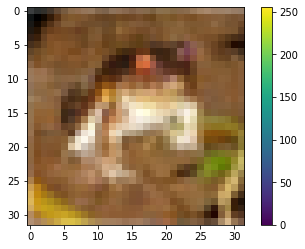

In [6]:
plt.imshow(train_img[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

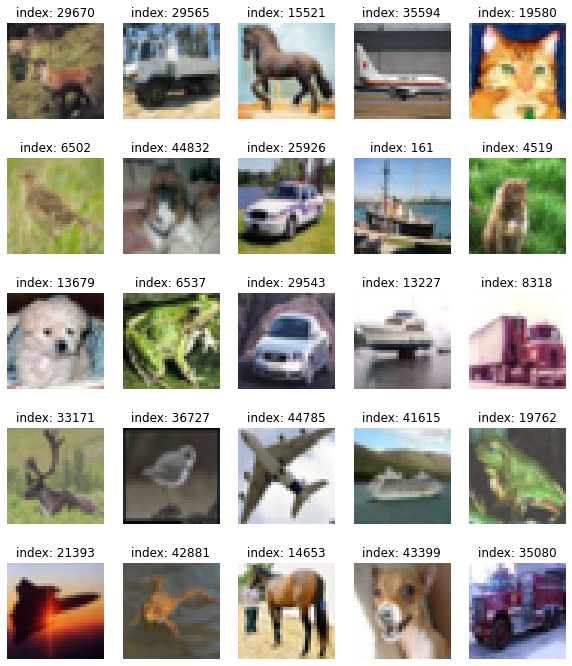

In [7]:
# 이미지 확인 - 랜덤 이미지 25개 
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_img[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

> **미니배치 학습**:
효율적인 메모리 활용과 학습시간 관리를 위해 적절한 사이즈로 잘라 학습을 진행합니다.

- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.
- 아래 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.
- 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

In [8]:
# 미니 배치 구현
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [94]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer -  이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- Conv2DTranspose 레이어를 이용해 이미지 사이즈를 넓혀줍니다.
- BatchNormalization 레이어는 신경망의 가중치를 정규화시켜줍니다.
- 중간층의 활성화 함수는 LeakyTeLU를 사용하였습니다.
- 마지막 활성화 함수는 tanh를 사용했는데, 정규화기킨 데이터셋과 동일하게 하기 위함입니다.

In [95]:
generator = make_generator_model()

generator.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_28 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 8, 8, 128)       

난수로 생상한 노이즈 벡터를 입력하여 결과물을 확인해봅니다.

In [96]:
noise = tf.random.normal([1, 100])

In [97]:
generated_image = generator(noise, training=False) # BN이 훈련과 추론시기의 행동이 다르므로 명시해주어야 함
generated_image.shape

TensorShape([1, 32, 32, 3])

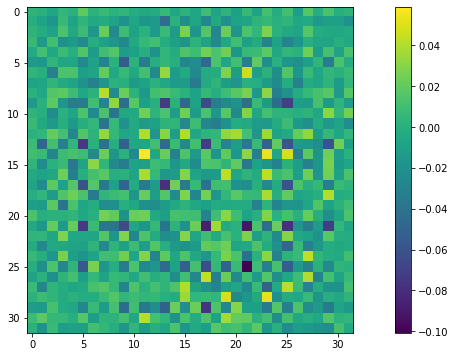

In [98]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

-1과 1사이의 값에서 이미지가 잘 생성되었습니다. 아직은 모델이 학습하지 않은 상태여서 의미없는 노이즈 이미지가 생성되었습니다.

## 3. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [99]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

- Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다.
- 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [100]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32768)           

위에서 생성했던 노이즈 이미지를 판별자에 넣어 판별 결과를 확인해 봅니다.

In [101]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00183472]], dtype=float32)>

## 4. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 4.1 손실함수(loss function)
- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.
- 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.
- 우리가 교차 엔트로피를 계산하기 위해 입력하는 값은 판별자가 판별한 값인데, 모든 실수값을 가질 수 있습니다.
-  tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다.
- from_logits를 True로 설정해주면 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

In [111]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [73]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [74]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [75]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 4.2 최적화 함수(Optimizer)
- 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 합니다.
- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어놓습니다.

In [76]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [77]:
noise_dim = 100
num_examples_to_generate = 16 # 생성하는 샘플 개수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 5. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [141]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 학습현황 확인

In [79]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    
    try: 
        plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    finally:
        plt.show()

#### Accuracy history graph

In [80]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### checkpoint

In [125]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints8'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

 ## 6. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.


In [126]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [123]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

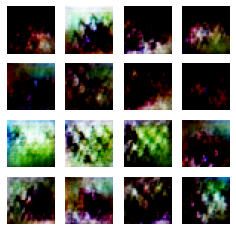

Time for training : 2910 sec


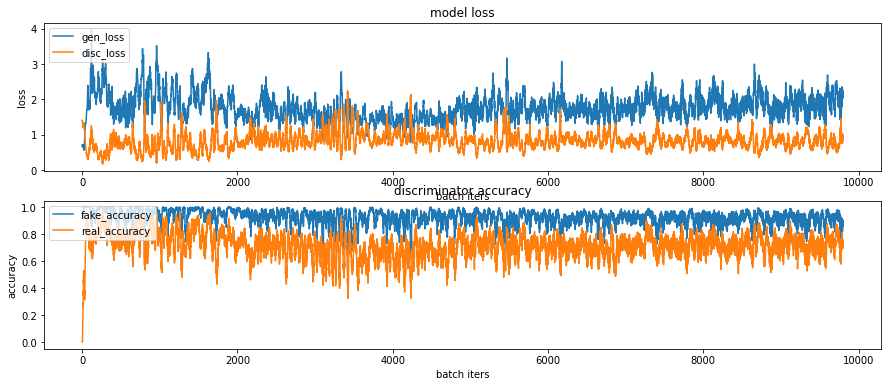

CPU times: user 48min 15s, sys: 33 s, total: 48min 48s
Wall time: 48min 31s


In [84]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

fake_accuracy가 계속 1에 가깝게 유지되고 있습니다, 이는 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻입니다.

#### 학습과정 시각화하기

In [85]:
# 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1125490 Sep  2 13:17 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## 7. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

__Tips__:
- optimizer 변경: Use SGD for discriminator and ADAM for generator
- activation function 변경:Leaky ReLU for discriminator and ReLU for generator
- Use dropout of 40 percent end of discrimination.
- 더 깊은 레이어 구조로 모델 설계(참조:https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)
- 500 ephochs

In [129]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    # foundation for 4x4 image
    model.add(layers.Dense(4*4*256, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # output layer
    model.add(layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same'))
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4096)              413696    
_________________________________________________________________
batch_normalization_39 (Batc (None, 4096)              16384     
_________________________________________________________________
re_lu_20 (ReLU)              (None, 4096)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_21 (ReLU)              (None, 8, 8, 128)       

In [130]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) # BN이 훈련과 추론시기의 행동이 다르므로 명시해주어야 함
generated_image.shape

TensorShape([1, 32, 32, 3])

In [131]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    # normal
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
      # downsample
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
     #classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 256)       

In [132]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00050069]], dtype=float32)>

In [133]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.SGD(1e-4)

In [134]:
noise_dim = 100
num_examples_to_generate = 16 # 생성하는 샘플 개수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [135]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [138]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [139]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

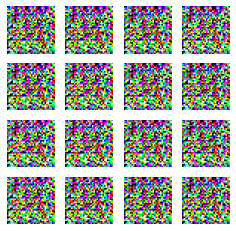

Epoch 3 | iter 151
Time for epoch 3 : 53 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [116]:
# 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif

-rw-r--r-- 1 root root 44742 Sep  2 13:47 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif


In [ ]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

***

## 프로젝트 정리

__루브릭__<br>

|평가문항|상세기준|
|:---|:---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|